In [1]:
import os, time, sys
from pathlib import Path
import sqlite3
import cv2
import numpy as np
from matplotlib import pyplot as plt

ROOT = Path().absolute()
PROJECT_PATH = ROOT / "outputs" / "sfm" / "framlingham_loftr"
#PROJECT_PATH = ROOT / "data" / "PROJECTS" / "framlinghouse_single_img_mc50"
IMAGE_PATH = ROOT / "datasets" / "framlingham" / "images"
print(IMAGE_PATH)

if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

COLMAP_PY_SCRIPTS_PATH = f"{ROOT}/third_party/colmap/scripts/python"
if COLMAP_PY_SCRIPTS_PATH not in sys.path:
    sys.path.append(COLMAP_PY_SCRIPTS_PATH)

/mnt/d/dev/python/Hierarchical-Localization/datasets/framlingham/images


In [2]:
from read_write_model import read_model, qvec2rotmat

# cameras, images, points3D
r_info = read_model(f"{PROJECT_PATH}", ".bin")
r_cams, r_imgs, r_pts = r_info

# load databases
r_conn = sqlite3.connect(f"{PROJECT_PATH}/database.db")
r_cursor = r_conn.cursor()

In [3]:
from database import pair_id_to_image_ids, image_ids_to_pair_id

# Note that COLMAP supports:
#      - 2D keypoints: (x, y)
#      - 4D keypoints: (x, y, theta, scale)
#      - 6D affine keypoints: (x, y, a_11, a_12, a_21, a_22)
# in the db each table has rows and columns! rows = number of entries, columns = format of entry (2D, 4D, 6D)
# e.g.: 1800 rows and 4 cols = 1800 entries of type 4D (x, y, theta, scale)

def name_part(full_name):
    split_name = full_name.split(".")
    if len(split_name) == 0:
        return full_name
    return split_name[0]

def read_image_by_id(cursor, img_id, path):
    cursor.execute(f"SELECT i.name, c.width, c.height FROM images as i, cameras as c WHERE c.camera_id = i.camera_id AND i.image_id = {img_id}")
    image_data = cursor.fetchone()
    if not image_data: return None
    image_name, width, height = image_data
    return cv2.imread(f"{IMAGE_PATH}/{image_name}")

def read_image_by_name(cursor, img_name, path):
    name_only = name_part(img_name)
    cursor.execute(f"SELECT i.name, c.width, c.height FROM images as i, cameras as c WHERE c.camera_id = i.camera_id AND i.name LIKE '{name_only}%'")
    image_data = cursor.fetchone()
    if not image_data: return None
    image_name, width, height = image_data
    return cv2.imread(f"{IMAGE_PATH}/{image_name}")

def get_image_id_from_name(cursor, img_name):
    name_only = name_part(img_name)
    sql = f"SELECT image_id FROM images WHERE name LIKE '{name_only}.%'"
    cursor.execute(sql)
    image_data = cursor.fetchone()
    print(name_only, image_data, sql)
    if not image_data: return None
    return image_data[0]

def get_image_name_from_id(cursor, img_id):
    cursor.execute(f"SELECT name FROM images WHERE image_id={img_id};")
    image_data = cursor.fetchone()
    if not image_data: return None
    img_name, = image_data
    return name_part(img_name)
    
def get_keypoints(cursor, img_id):
    cursor.execute(f"SELECT image_id, rows, cols, data FROM keypoints WHERE image_id={img_id}")
    result = cursor.fetchone()
    if not result: return None

    image_id, rows, cols, data = result
    if not data:
        return None
    dtype=np.float32
    shape=(-1, cols)
    coordinates = np.frombuffer(data, dtype=dtype).reshape(*shape)
    return {
        "image_id": int(image_id),
        "coordinates": coordinates
    }

# Get all matches
def get_all_matches(cursor):
    matches = []
    for pair_id, rows, cols, data in cursor.execute(f"SELECT pair_id, rows, cols, data FROM matches"):
        img1_id, img2_id = pair_id_to_image_ids(pair_id)
        image_matches = []
        if data:
            dtype=np.uint32
            shape=(-1, cols)
            image_matches = np.frombuffer(data, dtype=dtype).reshape(*shape)
        matches.append({
            "pair_id": int(pair_id),
            "image1_id": int(img1_id),
            "image2_id": int(img2_id),
            "image_matches": image_matches
        })
    return matches

def swap_matches_order(matches):
    # swap values in matches
    ret = matches.copy()
    ret[:, [0, 1]] = ret[:, [1, 0]]
    return ret

# Get matches for image pair
def get_matches(cursor, img1_id, img2_id):
    pair_id = int(image_ids_to_pair_id(img1_id, img2_id))
    cursor.execute(f"SELECT pair_id, rows, cols, data FROM matches WHERE pair_id={pair_id}")
    result = cursor.fetchone()
    if not result: return None
    
    _, rows, cols, data = result
    if not data: return None
    dtype=np.uint32
    shape=(-1, cols)
    image_matches = np.frombuffer(data, dtype=dtype).reshape(*shape)
    # FIX!!! use colmap pair_id deserialiaze to get the image IDs in the correct order
    # check if order is correct and if not just swap the match ids
    if int(pair_id_to_image_ids(pair_id)[0]) != int(img1_id):
        # swap values
        image_matches = swap_matches_order(image_matches)
    return {
        "pair_id": pair_id,
        "image1_id": int(img1_id),
        "image2_id": int(img2_id),
        "image_matches": image_matches
    }

# Get the matches that are of good enough quality
def get_inlier_matches(cursor, img1_id, img2_id):
    pair_id = int(image_ids_to_pair_id(img1_id, img2_id))
    cursor.execute(f"SELECT pair_id, rows, cols, data FROM two_view_geometries WHERE pair_id={pair_id};")
    result = cursor.fetchone()
    if not result: return None
    
    _, rows, cols, data = result
    if not data: return None
    dtype=np.uint32
    shape=(-1, cols)
    image_matches = np.frombuffer(data, dtype=dtype).reshape(*shape)
    # FIX!!! use colmap pair_id deserialiaze to get the image IDs in the correct order
    # check if order is correct and if not just swap the match ids
    if int(pair_id_to_image_ids(pair_id)[0]) != int(img1_id):
        # swap values
        image_matches = swap_matches_order(image_matches)
    return {
        "pair_id": pair_id,
        "image1_id": int(img1_id),
        "image2_id": int(img2_id),
        "image_matches": image_matches
    }

# Get the matches that are of not good enough quality
def get_outlier_matches(cursor, img1_id, img2_id):
    all_matches = get_matches(cursor, img1_id, img2_id)
    inlier_matches = get_inlier_matches(cursor, img1_id, img2_id)
    if not inlier_matches or not all_matches: return []
    
    outlier_matches = {
        "pair_id": all_matches["pair_id"],
        "image1_id": all_matches["image1_id"],
        "image2_id": all_matches["image2_id"],
        "image_matches": []
    }
    
    for match in all_matches["image_matches"]:
        if any((im == match).all() for im in inlier_matches["image_matches"]):
            continue
        outlier_matches["image_matches"].append(match)
    
    return outlier_matches

# get coordinates of matches
def get_matches_coords(cursor, matches):
    ret = []
    skipped_kps = []

    img1_kps = get_keypoints(cursor, matches["image1_id"])
    img2_kps = get_keypoints(cursor, matches["image2_id"])
    
    new_matches = dict(matches) # copy instance
    new_matches["image_matches"] = [] # clear old matches to be replaced by coords
    for im_m in matches["image_matches"]:
        img1_kp_index = im_m[0]
        img2_kp_index = im_m[1]
        img1_kp_coords = img1_kps["coordinates"]
        img2_kp_coords = img2_kps["coordinates"]
        img1_kp_coords_len = img1_kp_coords.shape[0]
        img2_kp_coords_len = img2_kp_coords.shape[0]

        # filter out matches that cannot be accessed
        # TODO: how do I properly get them?? This cannot be the ways??
        if img1_kp_index >= img1_kp_coords_len or img2_kp_index >= img2_kp_coords_len:
            skipped_kps.append((img1_kp_index, img2_kp_index))
            continue

        im_m_coords = [
            img1_kp_coords[img1_kp_index],
            img2_kp_coords[img2_kp_index]
        ]
        new_matches["image_matches"].append(im_m_coords)

    if len(skipped_kps) != 0: print(f"skipped keypoints: {len(skipped_kps)}")
    return new_matches

def get_filenames_in_folder(folder_path: Path):
    """Returns a list of filenames contained within the given folder.

    Args:
    folder_path (Path): The Path object representing the path to the folder from which to retrieve file names.

    Returns:
    list: A list of filenames as strings.
    """
    filenames = []  # Initialize an empty list to store filenames
    # Iterate over each item in the specified folder
    for entry in folder_path.iterdir():
        # Check if the entry is a file
        if entry.is_file():
            filenames.append(entry.name)  # Append the file name
    return filenames

In [4]:
import ipywidgets as widgets

image_files = get_filenames_in_folder(IMAGE_PATH)
w1 = widgets.Dropdown(
    options=image_files,
    value=image_files[0],
    description='First Image:',
    disabled=False,
)
w2 = widgets.Dropdown(
    options=image_files,
    value=image_files[1],
    description='Second Image:',
    disabled=False,
)

display(w1)
display(w2)

Dropdown(description='First Image:', options=('7Cam1.png', '7Cam10.png', '7Cam2.png', '7Cam3.png', '7Cam4.png'…

Dropdown(description='Second Image:', index=1, options=('7Cam1.png', '7Cam10.png', '7Cam2.png', '7Cam3.png', '…

In [5]:
r_img_name1 = name_part(w1.value)
r_img_name2 = name_part(w2.value)

# get image ids of comparing images
#r_img_name1 = get_image_name_from_id(r_cursor, 1)
#r_img_name2 = get_image_name_from_id(r_cursor, 3)
#r_img_name1 = "MAIN"
#r_img_name2 = "7-Cam10"

In [6]:
# Collect /Aggregate Useful Info
from tabulate import tabulate
from colorama import  Back, Style, Fore
import statistics

def read_mean_reprojection_error(model_points):
    errors = np.asarray([p[1].error for p in model_points.items()])
    return round(np.nanmean(errors), 2)

def read_mean_track_length(model_points):
    # get number of images the points occured
    tracks = np.asarray([ len(p[1].image_ids) for p in model_points.items()])
    return round(np.nanmean(tracks), 2)

def get_percentage(part, total):
    if total == 0: return ""
    ret = int(round((part/total)*100, 0))
    if abs(ret) > 100:
        color = Back.MAGENTA
    elif abs(ret) > 50:
        color = Back.LIGHTBLUE_EX
    elif abs(ret) > 30:
        color = Back.BLUE
    else: color = ""
    return f"{color}{'+' if ret > 0 else ''}{ret}%{Style.RESET_ALL}"

def get_kp_per_image(cursor):
    table = []
    for image_id, name, camera_id, kp_amount, in cursor.execute("SELECT i.image_id, i.name, i.camera_id, k.rows FROM images i, keypoints k WHERE i.image_id=k.image_id"):
        table.append([
            int(image_id),
            str(name_part(name)),
            camera_id,
            kp_amount
        ])
    #return tabulate(table, headers=['Img', 'Cam ID', 'Keypoints'], tablefmt='plain', showindex="always")
    return (table, ['Img ID', 'Img Name', 'Cam ID', 'Keypoints'])

def get_matches_per_image_pairs(cursor, im_max = None, im_min = None, im_med = None):
    table = []
    for i, md in enumerate(get_all_matches(cursor)):
        rows, = cursor.execute(f"SELECT rows FROM two_view_geometries WHERE pair_id={md['pair_id']}")
        matches = len(md['image_matches'])
        matches_ratio = int(round((rows[0]/matches) * 100, 0)) if matches > 0 else 0
        if matches_ratio == 0:
            matches_ratio_color = Back.LIGHTRED_EX
        elif matches_ratio < 50:
            matches_ratio_color = Back.RED
        elif matches_ratio < 75:
            matches_ratio_color = Back.YELLOW
        elif matches_ratio < 90:
            matches_ratio_color = Back.GREEN
        else:
            matches_ratio_color = Back.LIGHTGREEN_EX

        inlier_matches = int(rows[0])
        if im_max and int(im_max) == inlier_matches:
            im_matches_color = Back.GREEN
        elif im_min and int(im_min) == inlier_matches:
            im_matches_color = Back.RED
        elif im_med and int(im_med) == inlier_matches:
            im_matches_color = Back.BLUE
        else: im_matches_color = ""

        table.append([
            f"{Back.BLACK if md['image1_id']%2 == 0 else Back.LIGHTBLACK_EX}{md['image1_id']} / {md['image2_id']}{Style.RESET_ALL}",
            md['pair_id'],
            matches,
            f"{im_matches_color}{inlier_matches}{Style.RESET_ALL}",
            f"{matches_ratio_color}{matches_ratio}%{Style.RESET_ALL}"
        ])
    # returns tuple(table_body, table_headers)
    return (table, ['Img Pair', 'Img Pair ID', 'Feature Matches', 'Inlier Matches', 'Ratio'])

def get_inlier_matches_per_image_median(cursor):
    #inlier_matches = get_inlier_matches(cursor)
    #inlier_matches = [im['image_matches'].shape[0] for im in inlier_matches]
    inlier_matches = cursor.execute("SELECT rows FROM two_view_geometries")
    inlier_matches = [im[0] for im in cursor.fetchall()]
    return statistics.median(inlier_matches)


def run_sfm_analysis(cursor, points_model):
    cursor.execute("SELECT SUM(rows) FROM keypoints")
    total_keypoints, = cursor.fetchall()[0]
    cursor.execute("SELECT COUNT(*) FROM images")
    total_images, = cursor.fetchall()[0]
    avg_kp_per_image = round(total_keypoints/total_images, 2)
    cursor.execute("SELECT MIN(rows) FROM keypoints")
    min_keypoints, = cursor.fetchall()[0]
    cursor.execute("SELECT MAX(rows) FROM keypoints")
    max_keypoints, = cursor.fetchall()[0]
    
    cursor.execute("SELECT SUM(rows) FROM matches")
    total_match_amount, = cursor.fetchall()[0]
    cursor.execute("SELECT COUNT(*) FROM matches")
    total_image_pair_matches, = cursor.fetchall()[0]
    avg_matches_per_image_pair = round(total_match_amount/total_image_pair_matches, 2)
    cursor.execute("SELECT MIN(rows) FROM matches")
    min_matches, = cursor.fetchall()[0]
    cursor.execute("SELECT MAX(rows) FROM matches")
    max_matches, = cursor.fetchall()[0]
    
    cursor.execute("SELECT SUM(rows) FROM two_view_geometries")
    total_inlier_match_amount, = cursor.fetchall()[0]
    cursor.execute("SELECT COUNT(*) FROM two_view_geometries")
    total_image_pair_inlier_matches, = cursor.fetchall()[0]
    avg_inlier_matches_per_image_pair = round(total_inlier_match_amount/total_image_pair_inlier_matches, 2)
    cursor.execute("SELECT MIN(rows) FROM two_view_geometries")
    min_inlier_matches, = cursor.fetchall()[0]
    cursor.execute("SELECT MAX(rows) FROM two_view_geometries")
    max_inlier_matches, = cursor.fetchall()[0]
    imm_p_im = get_inlier_matches_per_image_median(cursor)
    
    return {
        "images": {
            "sum": total_images
        },
        "keypoints": {
            "min": min_keypoints,
            "max": max_keypoints,
            "avg": avg_kp_per_image,
            "sum": total_keypoints
        },
        "matches": {
            "min": min_matches,
            "max": max_matches,
            "avg": avg_matches_per_image_pair,
            "sum": total_match_amount
        },
        "inlier_matches": {
            "min": min_inlier_matches,
            "max": max_inlier_matches,
            "avg": avg_inlier_matches_per_image_pair,
            "med": imm_p_im,
            "sum": total_inlier_match_amount,
            "ratio": round(total_inlier_match_amount / total_match_amount, 2) # il matches / matches ratio
        },
        "extra": {
            "avg_track_length": read_mean_track_length(points_model),
            "avg_error": read_mean_reprojection_error(points_model)
        },
        "keypoints_table": get_kp_per_image(cursor),
        "matches_table": get_matches_per_image_pairs(cursor, im_max=max_inlier_matches, im_min=min_inlier_matches, im_med=imm_p_im)
    }

def pprint_sfm_analysis(analysis_result):
    table = []
    headers = ["Metric Name", "Value", "Unit"]
    table.append(["Total Features Found", analysis_result['keypoints']['sum'], None])
    #print(f"Total Features Found: {analysis_result['keypoints']['sum']}")
    table.append(["Total Images", analysis_result['images']['sum'], None])
    #print(f"Total Images: {analysis_result['images']['sum']}")
    table.append(["Avg. Features/Image", analysis_result['keypoints']['avg'], None])
    #print(f"Avg. Features/Image: {analysis_result['keypoints']['avg']}")
    table.append(["Lowest Features/Image", analysis_result['keypoints']['min'], None])
    #print(f"Lowest Features/Image: {analysis_result['keypoints']['min']}")
    table.append(["Highest Features/Image", analysis_result['keypoints']['max'], None])
    #print(f"Highest Features/Image: {analysis_result['keypoints']['max']}")
    #print("\n")

    table.append(["Total Feature Matches", analysis_result['matches']['sum'], None])
    #print(f"Total Feature Matches: {analysis_result['matches']['sum']}")
    table.append(["Avg. Feature Matches/Image Pair", analysis_result['matches']['avg'], None])
    #print(f"Avg. Feature Matches/Image Pair: {analysis_result['matches']['avg']}")
    table.append(["Lowest Feature Matches/Image Pair", analysis_result['matches']['min'], None])
    #print(f"Lowest Feature Matches/Image Pair: {analysis_result['matches']['min']}")
    table.append(["Highest Feature Matches/Image Pair", analysis_result['matches']['max'], None])
    #print(f"Highest Feature Matches/Image Pair: {analysis_result['matches']['max']}")
    #print("\n")

    table.append(["Total Inlier Feature Matches", analysis_result['inlier_matches']['sum'], None])
    #print(f"Total Inlier Feature Matches: {analysis_result['inlier_matches']['sum']}")
    table.append(["Avg. Inlier Feature Matches", analysis_result['inlier_matches']['avg'], None])
    #print(f"Avg. Feature Inlier Matches/Image Pair: {analysis_result['inlier_matches']['avg']}")
    # Median, because we might have a lot of outliers which might affect the result!
    table.append(["Median Inlier Feature Matches", analysis_result['inlier_matches']['med'], None])
    #print(f"Median for Feature Inlier Matches/Image Pair: {analysis_result['inlier_matches']['med']}")
    table.append(["Lowest Inlier Feature Matches", analysis_result['inlier_matches']['min'], None])
    #print(f"Lowest Feature Inlier Matches/Image Pair: {analysis_result['inlier_matches']['min']}")
    table.append(["Highest Inlier Feature Matches", analysis_result['inlier_matches']['max'], None])
    #print(f"Highest Feature Inlier Matches/Image Pair: {analysis_result['inlier_matches']['max']}")
    table.append(["Inlier Matches Ratio/Matches", int(analysis_result['inlier_matches']['ratio']*100), "%"])
    #print(f"Inlier Matches Ratio/Matches: {int(analysis_result['inlier_matches']['ratio']*100)} %")
    #print("\n")

    table.append(["Avg. Track Length", analysis_result['extra']['avg_track_length'], "Images"])
    #print(f"Avg. Track Length (Images): {analysis_result['extra']['avg_track_length']}")
    table.append(["Avg. Reprojection Error", analysis_result['extra']['avg_error'], "px"])
    #print(f"Avg. Reprojection Error (px): {analysis_result['extra']['avg_error']}")
    #print("\n")

    print("General Metrics ")
    print(
        tabulate(table, headers, tablefmt='plain', showindex="always")
    )
    print("\n")
    
    print("Images ")
    print(
        tabulate(*(analysis_result['keypoints_table']), tablefmt='plain', showindex="always")
    )
    print("\n")
    
    print("Feature Matches ")
    print(
        tabulate(*(analysis_result['matches_table']), tablefmt='plain', showindex="always")
    )
    return

analysis_result = run_sfm_analysis(r_cursor, r_pts)
pprint_sfm_analysis(analysis_result)

General Metrics 
    Metric Name                            Value  Unit
 0  Total Features Found                73751
 1  Total Images                           11
 2  Avg. Features/Image                  6704.64
 3  Lowest Features/Image                1160
 4  Highest Features/Image               8192
 5  Total Feature Matches               52624
 6  Avg. Feature Matches/Image Pair       956.8
 7  Lowest Feature Matches/Image Pair      20
 8  Highest Feature Matches/Image Pair   2472
 9  Total Inlier Feature Matches        51620
10  Avg. Inlier Feature Matches           938.55
11  Median Inlier Feature Matches         925
12  Lowest Inlier Feature Matches          18
13  Highest Inlier Feature Matches       2466
14  Inlier Matches Ratio/Matches           98     %
15  Avg. Track Length                       4.32  Images
16  Avg. Reprojection Error                 0.58  px


Images 
      Img ID  Img Name      Cam ID    Keypoints
 0         1  7Cam1              1         8192
 1      

7Cam1 (1,) SELECT image_id FROM images WHERE name LIKE '7Cam1.%'
7Cam10 (2,) SELECT image_id FROM images WHERE name LIKE '7Cam10.%'
1 2


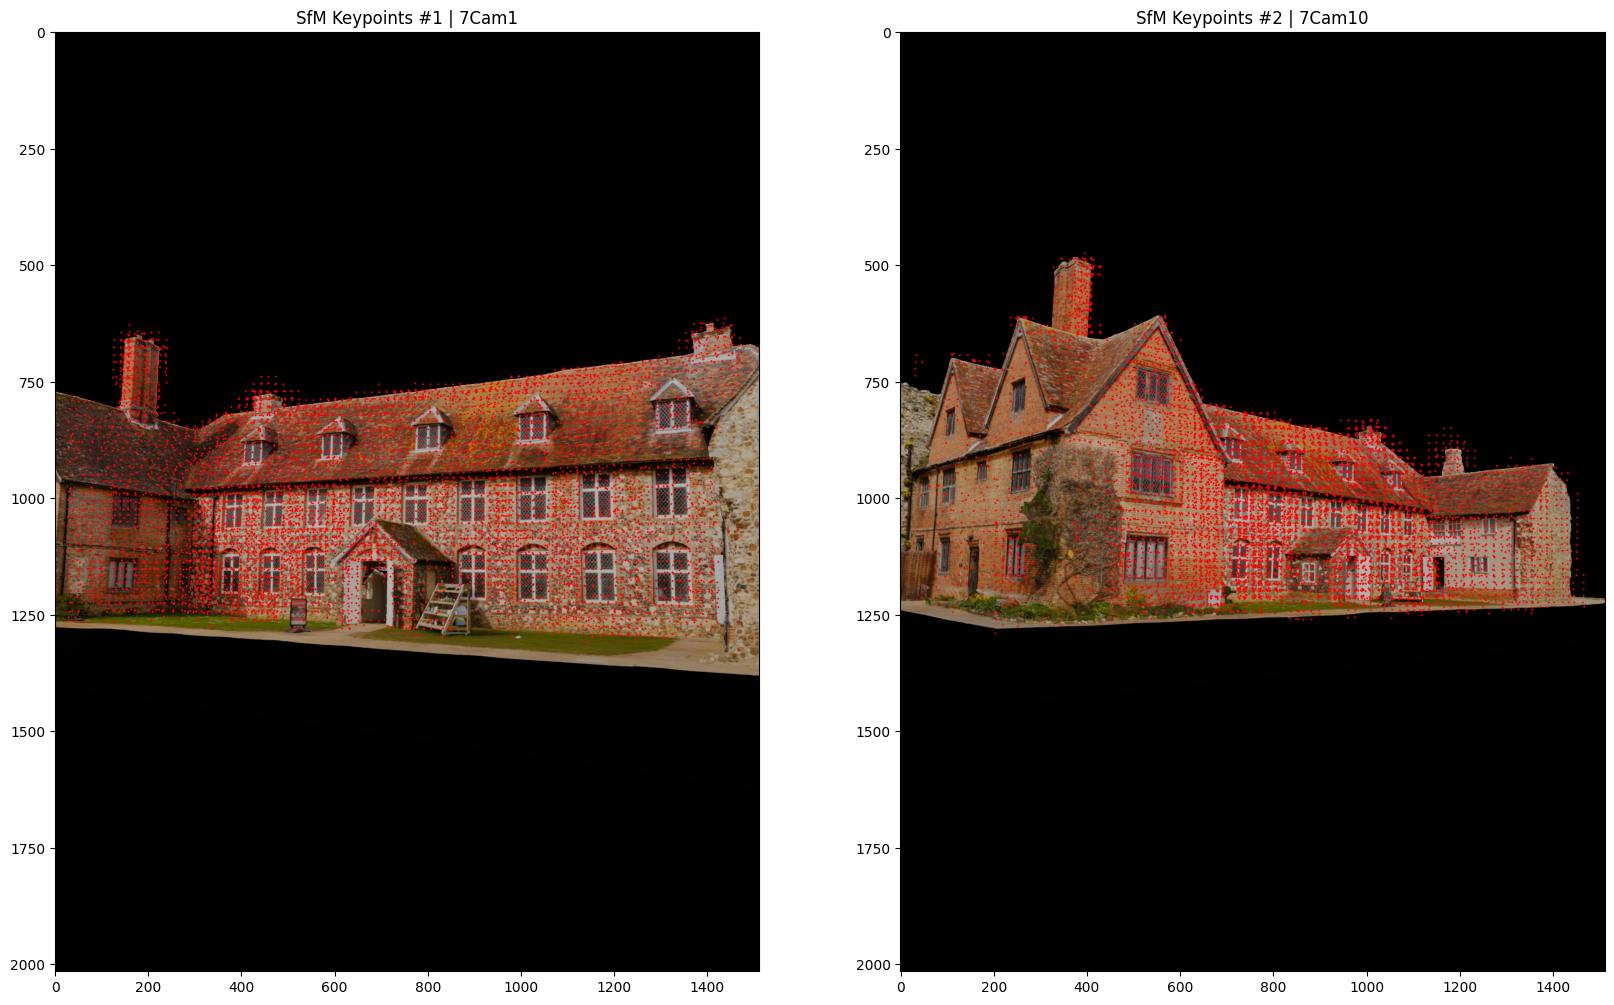

In [7]:
# Display Features for 2 images
r_img_id1 = get_image_id_from_name(r_cursor, r_img_name1)
r_img_id2 = get_image_id_from_name(r_cursor, r_img_name2)
print(r_img_id1, r_img_id2)

# get image data from ids
r_image1 = read_image_by_id(r_cursor, r_img_id1, PROJECT_PATH)
r_image2 = read_image_by_id(r_cursor, r_img_id2, PROJECT_PATH)

# get kps for both images
r_kps1 = get_keypoints(r_cursor, r_img_id1)
for i, kpc in enumerate(r_kps1["coordinates"]):
    x = kpc[0]
    y = kpc[1]
    cv2.circle(r_image1, (int(x), int(y)), radius=2, color=(0,  0,  255), thickness=-1)

r_kps2 = get_keypoints(r_cursor, r_img_id2)
for i, kpc in enumerate(r_kps2["coordinates"]):
    x = kpc[0]
    y = kpc[1]
    cv2.circle(r_image2, (int(x), int(y)), radius=2, color=(0,  0,  255), thickness=-1)

# convert images to OpenCV images
r_RGB_img1 = cv2.cvtColor(r_image1, cv2.COLOR_BGR2RGB)
r_RGB_img2 = cv2.cvtColor(r_image2, cv2.COLOR_BGR2RGB)

# draw graph
plt.rcParams["figure.figsize"] = (20,20)
fig, axarr = plt.subplots(1,2)
axarr[0].imshow(r_RGB_img1)
axarr[0].set_title(f"SfM Keypoints #{r_img_id1} | {r_img_name1}")
axarr[1].imshow(r_RGB_img2)
axarr[1].set_title(f"SfM Keypoints #{r_img_id2} | {r_img_name2}")

plt.show()

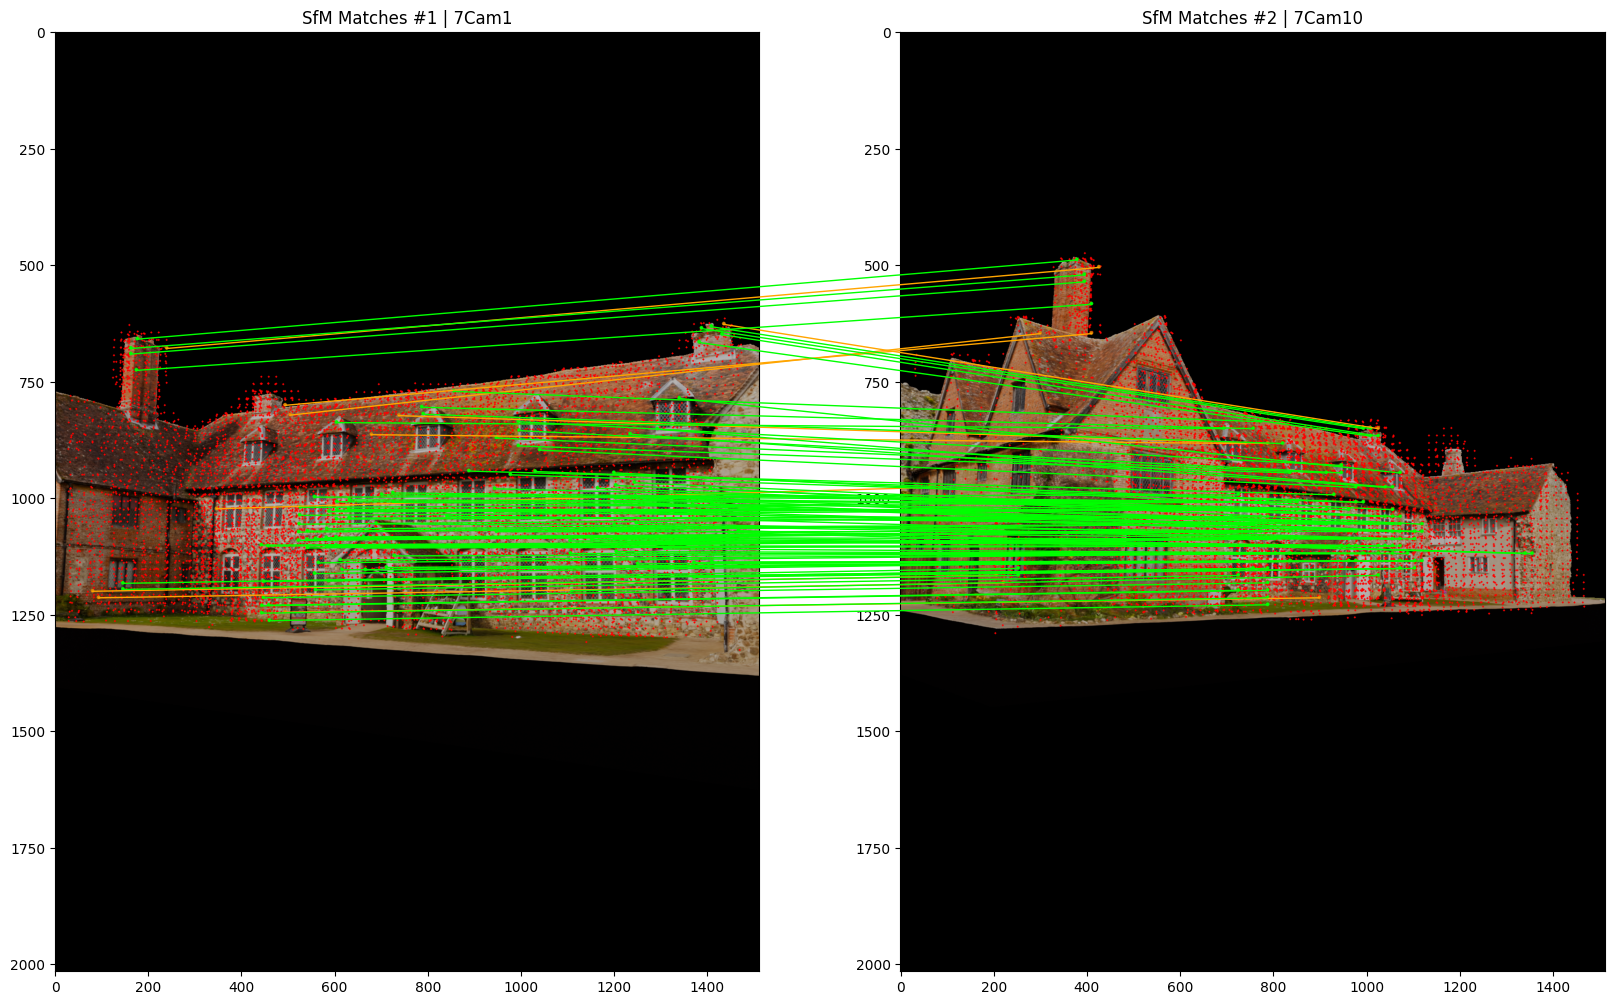

In [8]:
# Display Matched Features on Top (with option of connecting lines between features in images)
from matplotlib.patches import ConnectionPatch

# get inlier and outlier matches
outlier_matches = get_outlier_matches(r_cursor, r_img_id1, r_img_id2)
inlier_matches = get_inlier_matches(r_cursor, r_img_id1, r_img_id2)

def draw_points(matches, color, image1, image2):
    for i, kpc in enumerate(matches):
        kpc1 = kpc[0]
        kpc2 = kpc[1]
        kpc1_x = kpc1[0]
        kpc1_y = kpc1[1]
        kpc2_x = kpc2[0]
        kpc2_y = kpc2[1]
        radius = 4
        cv2.circle(image1, (int(kpc1_x), int(kpc1_y)), radius=radius, color=color, thickness=-1)
        cv2.circle(image2, (int(kpc2_x), int(kpc2_y)), radius=radius, color=color, thickness=-1)
    return

def draw_lines(matches, color, plt_array, figure):
    for i, kpc in enumerate(matches):
        kpc1 = kpc[0]
        kpc2 = kpc[1]
        kpc1_x = kpc1[0]
        kpc1_y = kpc1[1]
        kpc2_x = kpc2[0]
        kpc2_y = kpc2[1]
        
        # Create a connection patch between the two subplots
        con = ConnectionPatch(xyA=(kpc1_x, kpc1_y), xyB=(kpc2_x, kpc2_y),
                                coordsA="data", coordsB="data",
                                axesA=plt_array[0], axesB=plt_array[1], color=color)
        # Add the connection patch to the figure, not the axes
        figure.add_artist(con)
    return

if len(outlier_matches) != 0:
    #raise Exception("No shared feature matches between both images!")

    # get inlier and outlier points coordinates
    outlier_matches_coords = get_matches_coords(r_cursor, outlier_matches)
    inlier_matches_coords = get_matches_coords(r_cursor, inlier_matches)

    draw_points(outlier_matches_coords["image_matches"], (0,  133,  219), r_image1, r_image2)
    draw_points(inlier_matches_coords["image_matches"], (0,  255,  0), r_image1, r_image2)

r_RGB_img1 = cv2.cvtColor(r_image1, cv2.COLOR_BGR2RGB)
r_RGB_img2 = cv2.cvtColor(r_image2, cv2.COLOR_BGR2RGB)

plt.rcParams["figure.figsize"] = (20,20)
fig, axarr = plt.subplots(1,2)
axarr[0].imshow(r_RGB_img1)
axarr[0].set_title(f"SfM Matches #{r_img_id1} | {r_img_name1}")
axarr[1].imshow(r_RGB_img2)
axarr[1].set_title(f"SfM Matches #{r_img_id2} | {r_img_name2}")

if len(outlier_matches) != 0:
    # Loop through each keypoint pair and draw lines
    draw_lines(outlier_matches_coords["image_matches"], "orange", axarr, fig)
    draw_lines(inlier_matches_coords["image_matches"], "lime", axarr, fig)

plt.show()